In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_label(x):
    if x==0:
        return 'Left'
    elif x==1:
        return 'Right'
    elif x==2:
        return 'Up'
    elif x==3:
        return 'Down'

In [3]:
class WindyGridWorld:
    
    def __init__(self, n, terminal_state, windy_blocks, steps, on_policy = 'on-policy', verbose=False):
        
        self.grid_size = n
        self.terminal_state = terminal_state
        self.windy_blocks = windy_blocks
        self.on_policy = on_policy
        self.steps = steps
        self.verbose = verbose
        self.gamma = 0.1
        
        self.Q = np.zeros((self.grid_size, self.grid_size, 4)) + 0.25
        
        self.actions = [(0,-1), (0, 1), (-1,0), (1, 0)]# Left, Right, Up, Down

        #Equi-probable action selection at each state for all actions
        self.policy = np.random.randint(1,4,size = (self.grid_size, self.grid_size))
                
        if self.verbose:
            print("Shape of Q", self.Q.shape)
            print("Shape of Policy", self.policy.shape)
            print("Initial State-Action/Q Function", *self.Q, sep='\n',end='\n\n')
            print("Initial Policy", *self.policy, sep='\n',end='\n\n')
        
    def _get_reward(self, x, y):
        if x==self.terminal_state[0] and y==self.terminal_state[1]:
            return 300
        return -1
    
    def _get_next_state(self, x, y, a):
        
        if x+a[0]!=-1 and x+a[0]!=self.grid_size:
            x = x + a[0]
        if y+a[1]!=-1 and y+a[1]!=self.grid_size:
            y = y + a[1]
        if x in self.windy_blocks[0] and y in self.windy_blocks[1]:
            if x-1!=-1:
                x-=1
        return x,y
        
    def play(self, epochs = 100, threshold = 1e-8):
        
        if self.on_policy == 'on-policy':
            res = self._play_n_step_on_policy(epochs, threshold)
            
            fig, ax = plt.subplots(figsize=(self.grid_size*2, self.grid_size*2))
            anotations = np.array(list(map(get_label, self.policy.reshape(-1,1)))).reshape(self.policy.shape)
            anotations[self.terminal_state[0], self.terminal_state[1]] = 'Terminal'
            sns.heatmap(self.policy, annot=anotations, fmt='', cmap='Blues', ax = ax)
            plt.show()
            
            if self.verbose:
                print("Final Policy:")
                print(*self.policy, sep = '\n', end = '\n\n')
                print("Final State-Action/Q Function:")
                print(*self.Q, sep = '\n', end = '\n\n')
                
            return res
        
        elif self.on_policy == 'off-policy':
            res = self._play_n_step_off_policy(epochs, threshold)
            
            fig, ax = plt.subplots(figsize=(self.grid_size*2, self.grid_size*2))
            anotations = np.array(list(map(get_label, self.policy.reshape(-1,1)))).reshape(self.policy.shape)
            anotations[self.terminal_state[0], self.terminal_state[1]] = 'Terminal'
            sns.heatmap(self.policy, annot=anotations, fmt='', cmap='Blues', ax = ax)
            plt.show()
            
            if self.verbose:
                print("Final Policy:")
                print(*self.policy, sep = '\n', end = '\n\n')
                print("Final State-Action/Q Function:")
                print(*self.Q, sep = '\n', end = '\n\n')
                
            return res
        
    def _get_action(self, x,y):
        
        m = np.round(np.min(self.Q[x][y])-1, 3)
        probs = (np.round(self.Q[x][y], 5)-m) / np.sum(np.round(self.Q[x][y], 5) - m)
        try:
            
            return np.random.choice([0,1,2,3],p=probs)
        except:
            print(m,probs)
    
    def _get_unform_action(self):
        return np.random.choice([0,1,2,3], p = [0.25, 0.25, 0.25, 0.25])
    
    def _get_policy_ratio(self, x, y, action):
        m = np.round(np.min(self.Q[x][y])-1, 3)
        probs = (np.round(self.Q[x][y], 5)-m) / np.sum(np.round(self.Q[x][y], 5) - m)
        return probs[action]/0.25
    
    def _play_n_step_on_policy(self, epochs, threshold):
        
        iters = 0
        while True:
            
            iters+=1
            x=0
            y=0
            diff = 0
            rewards = []
            next_action = 0
            action = self._get_action(x,y)
            old_Q = np.array(self.Q)
            length = 0
            avg_length = []
            
            while True:
                
                    length+=1
                    new_x, new_y = self._get_next_state(x,y,self.actions[action])
                    reward = self._get_reward(new_x, new_y)
                    rewards.append(reward)
                    
                    if self.verbose:
                        print("X, Y, Action, Rewards:", [x,y,action,rewards])
                    
                    if reward<0:
                        next_action = self._get_action(x,y)                        
                    
                    if self.steps < len(rewards):
                        
                        G = 0
                        if self.verbose:
                            print("rewards taken:", rewards[-1*self.steps:])
                        for i, g in enumerate(rewards[-1*self.steps:]):
                            G += ((self.gamma ** i) * g)
                    
                        G += ((self.gamma ** self.steps) * self.Q[new_x, new_y, next_action])
                        
                        self.Q[x,y,action] = self.Q[x,y,action] + 0.1*(G - self.Q[x,y,action])

                        self.policy[x,y] = np.argmax(self.Q[x][y])
                    
                    x, y, action = new_x, new_y, next_action
                    
                    if reward>0:
                        break

            avg_length.append(length)
            diff = np.mean(np.square(old_Q-self.Q))
            
            if self.verbose:
                print('IDs & Difference(MSE):', id(old_Q), id(self.Q), diff)
                
                        
            if self.verbose:
                print("Q function at iter:", iters)
                print(*self.Q, sep = '\n', end = '\n\n')
            
            if self.verbose:
                print("Policy at iter:", iters)
                print(*self.policy, sep = '\n', end = '\n\n')
            
            if epochs==iters or diff < threshold:
                return diff, iters, np.mean(avg_length)
            
    def _play_n_step_off_policy(self, epochs, threshold):
        
        iters = 0
        while True:
            
            iters+=1
            x=0
            y=0
            diff = 0
            rewards = []
            prob_ratios = []
            next_action = 0
            action = self._get_unform_action()
            old_Q = np.array(self.Q)
            length = 0
            avg_length = []
            
            while True:
                
                    length += 1
                    prob_ratios.append(self._get_policy_ratio(x,y,action))
                    
                    new_x, new_y = self._get_next_state(x,y,self.actions[action])
                    
                    reward = self._get_reward(new_x, new_y)
                    rewards.append(reward)
                    
                    if self.verbose:
                        print("X, Y, Action, Rewards:", [x,y,action,rewards])
                    
                    if reward<0:
                        next_action = self._get_unform_action()                        
                    
                    if self.steps < len(rewards):
                        
                        P = 1
                        for p in prob_ratios[-1*self.steps:]:
                            P = P * p
                        
                        G = 0
                        if self.verbose:
                            print("rewards taken:", rewards[-1*self.steps:])
                        for i, g in enumerate(rewards[-1*self.steps:]):
                            G += ((self.gamma ** i) * g)
                    
                        G += ((self.gamma ** self.steps) * self.Q[new_x, new_y, next_action])
                        
                        self.Q[x,y,action] = self.Q[x,y,action] + 0.1 * P * (G - self.Q[x,y,action])

                        self.policy[x,y] = np.argmax(self.Q[x][y])
                    
                    x, y, action = new_x, new_y, next_action
                    
                    if reward>0:
                        break

            avg_length.append(length)
            diff = np.mean(np.square(old_Q-self.Q))
            
            if self.verbose:
                print('IDs & Difference(MSE):', id(old_Q), id(self.Q), diff)
                
                        
            if self.verbose:
                print("Q function at iter:", iters)
                print(*self.Q, sep = '\n', end = '\n\n')
            
            if self.verbose:
                print("Policy at iter:", iters)
                print(*self.policy, sep = '\n', end = '\n\n')
            
            if epochs==iters or diff < threshold:
                return diff, iters, np.mean(avg_length)

# On Policy

TD with step size: 1


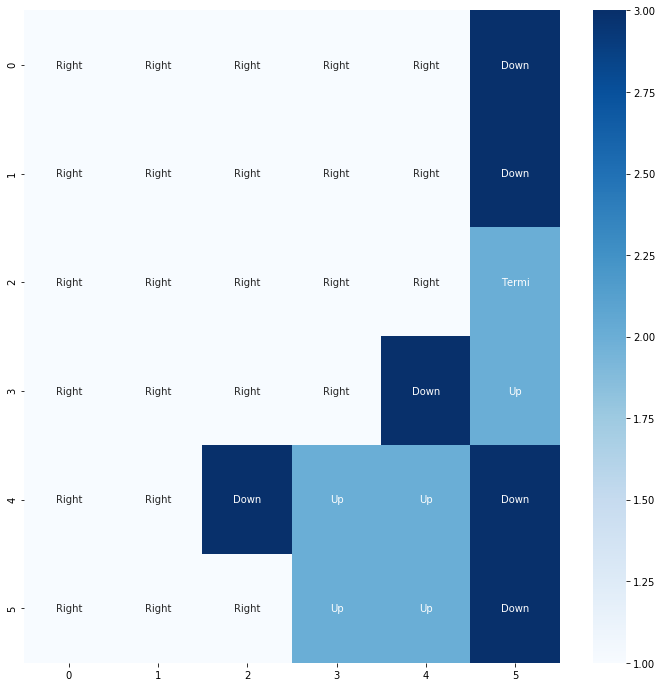

Average Length of Episode: 26.0
TD with step size: 2


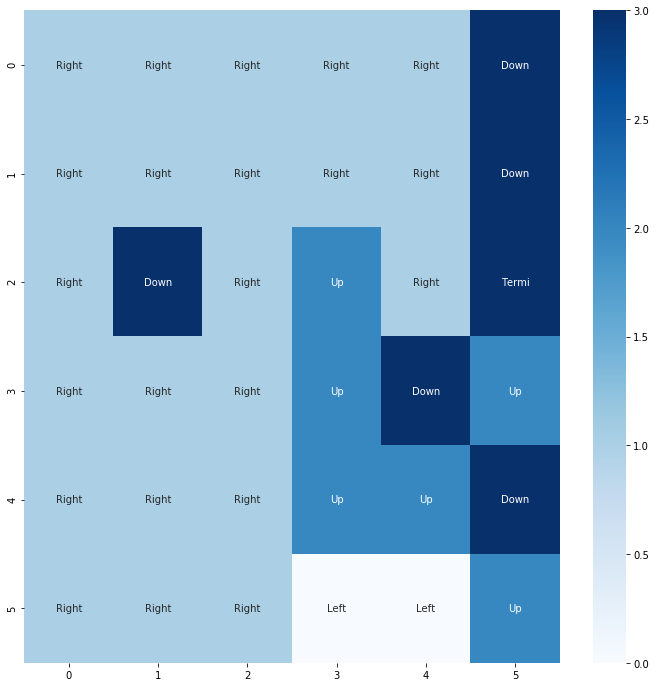

Average Length of Episode: 125.0
TD with step size: 3


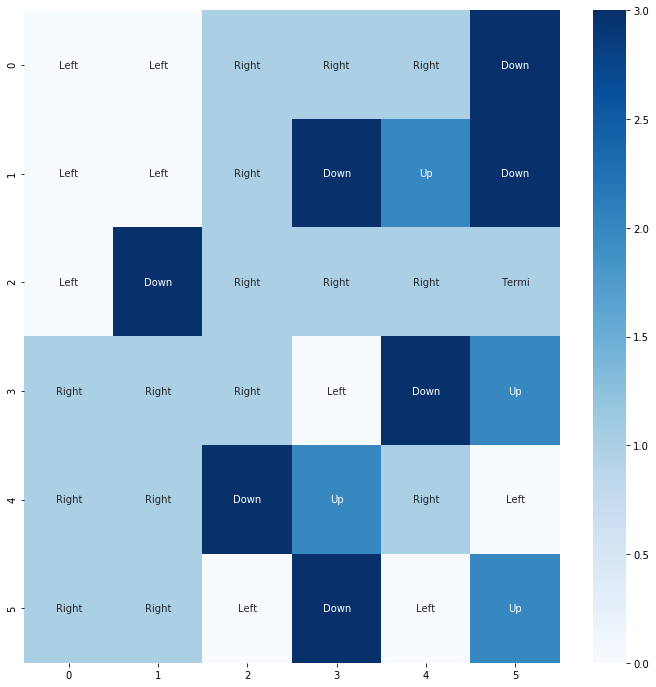

Average Length of Episode: 60.0
TD with step size: 4


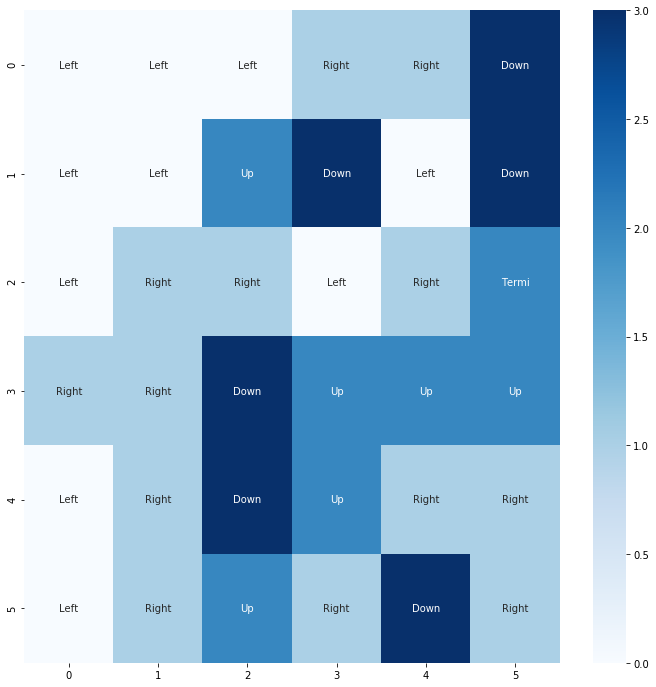

Average Length of Episode: 192.0
TD with step size: 5


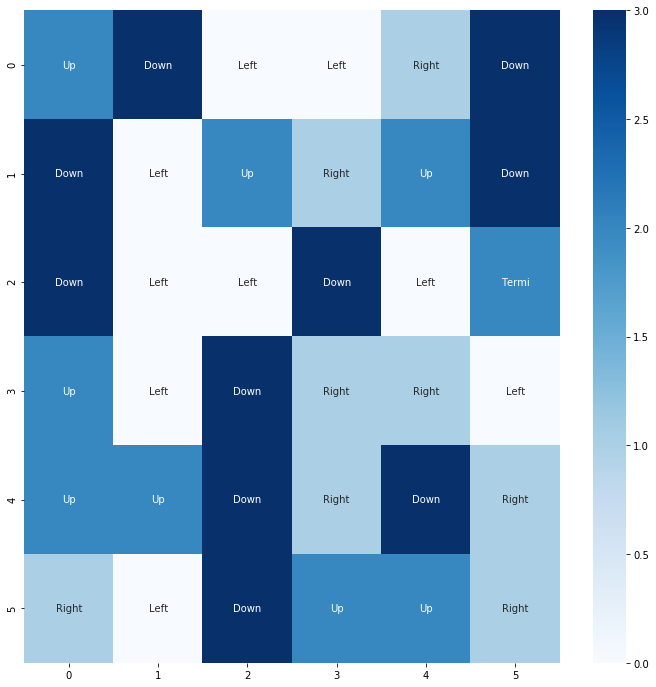

Average Length of Episode: 12.0


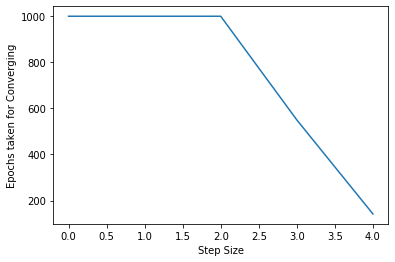

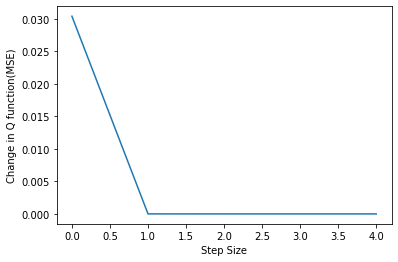

Epochs Count [1000, 1000, 1000, 550, 142]
Difference(MSE) Value [0.0303809530218535, 4.192387179896136e-06, 2.3058218092312479e-10, 4.893137146753936e-17, 2.637108915841276e-17]


In [4]:
blocks = [[1,2,3,4],[2,3,4]]

epochs_count = []
diff_count = []

for i in range(1,6):
    print("TD with step size:", i)
    game = WindyGridWorld(6, (2,5), windy_blocks = blocks, steps=i, on_policy = 'on-policy', verbose=False)
    diff, epochs, avg_episode_length = game.play(epochs=1000, threshold=1e-16)
    print("Average Length of Episode:", avg_episode_length)
    epochs_count.append(epochs)
    diff_count.append(diff)

plt.plot(epochs_count)
plt.xlabel('Step Size')
plt.ylabel('Epochs taken for Converging')
plt.show()
plt.plot(diff_count)
plt.xlabel('Step Size')
plt.ylabel('Change in Q function(MSE)')
plt.show()

print('Epochs Count', epochs_count)
print('Difference(MSE) Value', diff_count)

# Off-Policy

TD with step size: 1


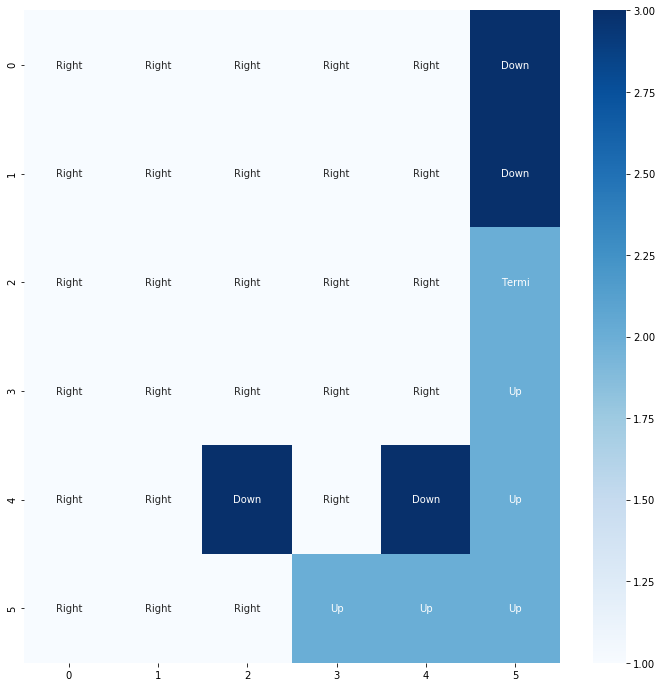

Average Length of Episode: 292.0
TD with step size: 2


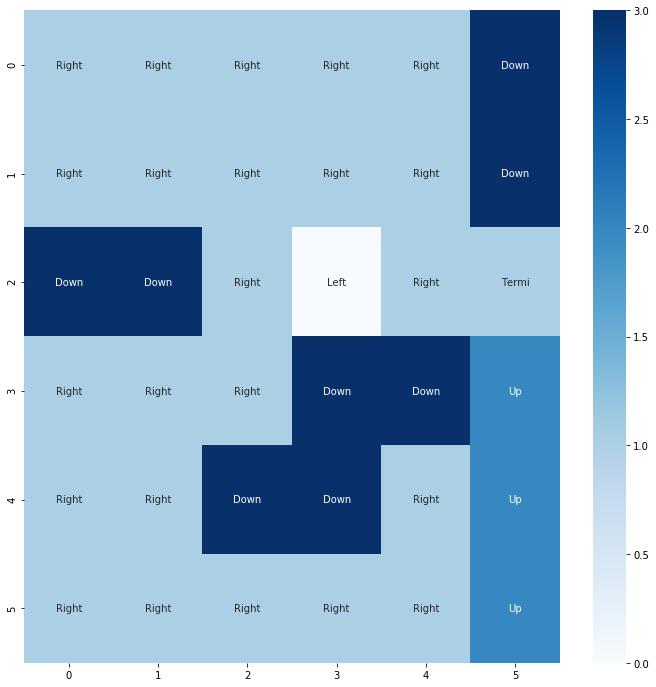

Average Length of Episode: 99.0
TD with step size: 3


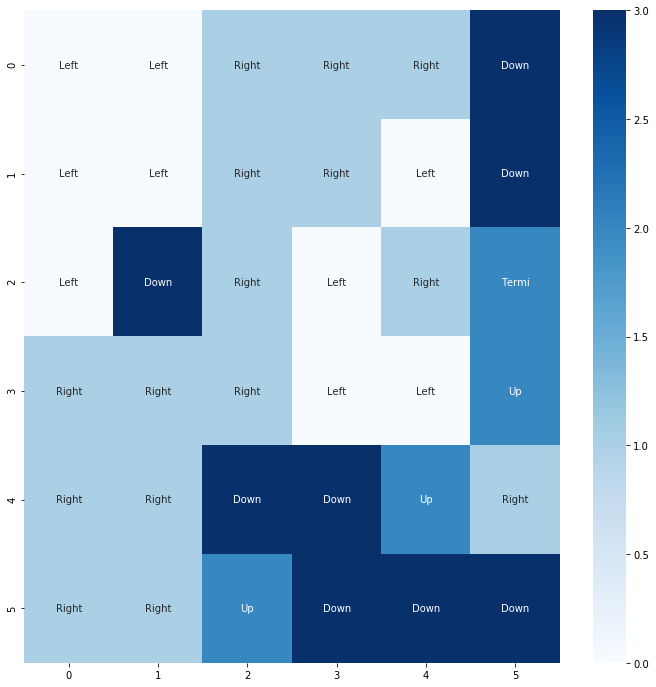

Average Length of Episode: 79.0
TD with step size: 4


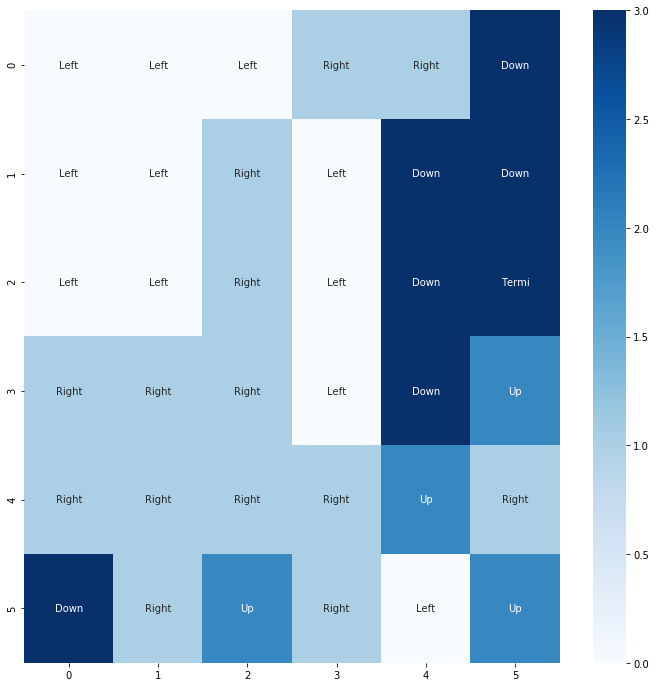

Average Length of Episode: 41.0
TD with step size: 5


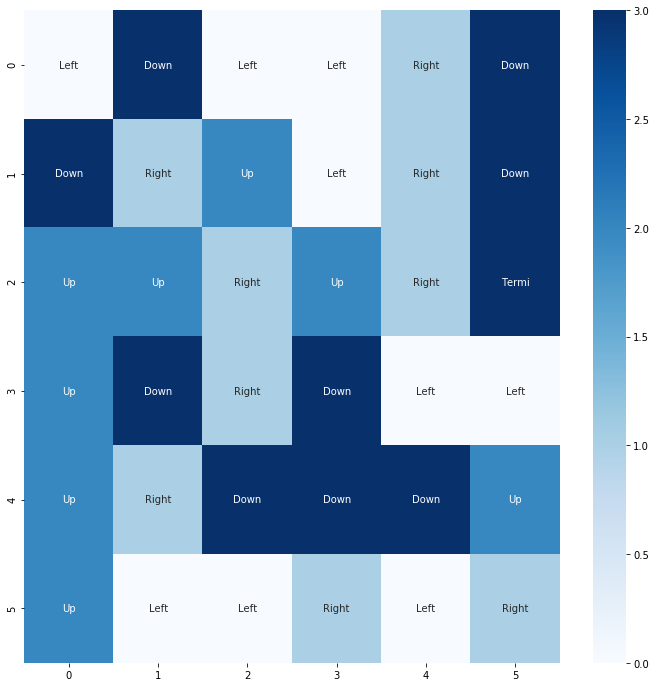

Average Length of Episode: 116.0


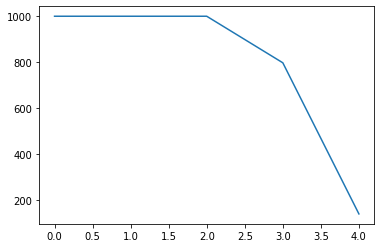

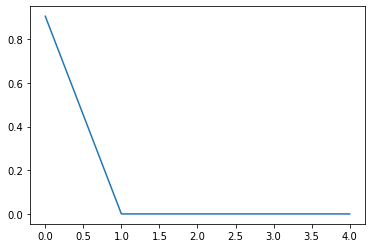

Epochs Count [1000, 1000, 1000, 797, 138]
Difference(MSE) Value [0.9057833289626599, 3.098847482510231e-07, 3.611783031012206e-10, 5.980695904092187e-17, 6.353259963110444e-17]


In [5]:
blocks = [[1,2,3,4],[2,3,4]]

epochs_count = []
diff_count = []

for i in range(1,6):
    print("TD with step size:", i)
    game = WindyGridWorld(6, (2,5), windy_blocks = blocks, steps=i, on_policy = 'off-policy', verbose=False)
    diff, epochs, avg_episode_length = game.play(epochs=1000, threshold=1e-16)
    print("Average Length of Episode:", avg_episode_length)
    epochs_count.append(epochs)
    diff_count.append(diff)

plt.plot(epochs_count)
plt.show()
plt.plot(diff_count)
plt.show()

print('Epochs Count', epochs_count)
print('Difference(MSE) Value', diff_count)

### Deductions/Observations

<ul>
    <li>Terminal state & the bottom most state of windy region(3,2 for 4x4 matrix) will never be explored/updated and hence the Q function and policy is never changed.</li>
    <li>Due to simple problem and less number of states there is no significant improvement in On-policy methods and Off-policy methods.</li>
    <li>Epochs: Convergence is achieved faster when the step size is greater than 3.</li>
</ul>